# Intro to GenerateDonutDirectDetectTask

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: 2023-01-26 <br>
Software Versions:
  - `ts_wep`: **v4.2.0**
  - `lsst_distrib`: **w_2023_03**

## Notebook Objective:

This notebook shows how to configure and run `GenerateDonutDirectDetectTask` and how to integrate it into the rest of the WEP pipeline.

## Logistics

This notebook is meant to be run on the Rubin USDF notebook portal: https://usdf-rsp.slac.stanford.edu/.

## Imports

In [1]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from astropy.visualization import ZScaleInterval
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Task
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
# For WCS Fitting
import lsst.geom
import lsst.afw.table as afwTable
import lsst.meas.base as measBase
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.meas.astrom import AstrometryTask
from lsst.meas.algorithms import MagnitudeLimit
from lsst.meas.algorithms.loadReferenceObjects import LoadReferenceObjectsConfig, ReferenceObjectLoader
from lsst.meas.algorithms.sourceSelector import ReferenceSourceSelectorConfig, ReferenceSourceSelectorTask

## Load data

For this notebook we will use real images from the Rubin Auxilliary Telescope (AuxTel). We load them from the USDF butler.

In [3]:
butler = Butler('/sdf/data/rubin/repo/main/',
                          collections=['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook'])
datasetRefOrType='quickLookExp'
year='2022'
monthDay='0407'
exposure_intra =  butler.get(datasetRefOrType, 
                                 dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00156')}, 
                                )
exposure_extra = butler.get(datasetRefOrType, 
                                dataId={'instrument':'LATISS', 'detector':0, 
                                    'exposure':int(f'{year}{monthDay}00157')}, 
                               )
camera = butler.get('camera', {'instrument': 'LATISS'})

## Task Configuration

The new `GenerateDonutDirectDetectTask` has some original configuration parameters and some from the newly added class `DonutQuickMeasurementTask` which is a daughter class of `QuickFrameMeasurementTask` from the `pipe_tasks` package and found [here](https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/quickFrameMeasurement.py). Additionally since the task implements `DonutSourceSelectorTask` as a second possible subtask there are configurations for that task that can be implemented as well.

In [4]:
GenerateDonutDirectDetectTaskConfig()

lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTaskConfig(saveMetadata=True, saveLogOutput=True, measurementTask={'installPsf': {'fwhm': 10.0, 'width': 11}, 'maxNonRoundness': 5.0, 'maxExtendedness': 100.0, 'doExtendednessCut': False, 'centroidPixelPercentile': 90.0, 'doCheckCentroidPixelValue': True, 'initialPsfWidth': 10.0, 'nSigmaDetection': 20.0, 'nPixMinDetection': 10, 'donutDiameter': 400, 'initialCutoutPadding': 5, 'doPreConvolution': True}, donutDiameter=400, opticalModel='offAxis', instObscuration=0.61, instFocalLength=10.312, instApertureDiameter=8.36, instPixelSize=1e-05, initialCutoutPadding=5, donutSelector={'xCoordField': 'centroid_x', 'yCoordField': 'centroid_y', 'useCustomMagLimit': False, 'magMax': 99.0, 'magMin': -99.0, 'maxFieldDist': 1.813, 'unblendedSeparation': 160, 'minBlendedSeparation': 120, 'isolatedMagDiff': 2.0, 'sourceLimit': -1, 'maxBlended': 0}, doDonutSelection=True, connections={'exposure': 'postISRCCD', 'donutCatalog': 'donutCa

### Configurations to define the instrument for GenerateDonutDirectDetectTask

Before running the donut detection we pre-convolve the images with a donut template. Therefore we have a set of configurations that help to define the instrument and properly generate a donut template. The default values come from the values needed to run on LSST CWFS. The configurations are:

- `opticalModel`: Specify the optical model (offAxis, paraxial, onAxis). Default = "offAxis". **Note**: If using AuxTel this must be set to "onAxis".
- `instObscuration`: Obscuration (inner_radius / outer_radius of M1M3). Default = 0.61.
- `instFocalLength`: Instrument Focal Length in m. Default = 10.312.
- `instApertureDiameter`: Instrument Aperture Diameter in m. Default = 8.36.
- `instDefocalOffset`: Instrument defocal offset in mm. If None then will get this from the focusZ value in exposure visitInfo. Default = None.
- `instPixelSize`: Instrument Pixel Size in m. Default = 10.0e-6.

### Configurations passed to DonutQuickMeasurementTask 

`GenerateDonutDirectDetectTask` uses `DonutQuickMeasurementTask` for quick source detection and measurement. `DonutQuickMeasurementTask` has its own set of configuration parameters mostly inherited from `QuickFrameMeasurementTask`.

A number of these configurations allow shape cuts to filter the initial detected catalog such as:
- `maxNonRoundness`: Ratio of xx to yy (or vice versa) above which to cut, in order to exclude spectra. Default = 5.
- `maxExtendedness`: Max absolute value of xx and yy above which to cut, in order to exclude large/things. Default = 100.
- `doExtendednessCut`: Apply the extendeness cut, as defined by maxExtendedness. Default = False.

Others that are relevant set the minimum detection thresholds:
- `nSigmaDetection`: Number of sigma for the detection limit. Default = 20.
- `nPixMinDetection`: Minimum number of pixels in a detected source. Default = 10.

Finally, as mentioned above `DonutQuickMeasurementTask` has a pre-convolution step with a donut template that helps with detection but this pre-convolution is optional and can be turned on or off with the following parameter:
- `doPreConvolution`: Set to true to perform a preconvolution of the image with a donut template. Default = True.

### Additional Configurations for GenerateDonutDirectDetectTask
- `donutDiameter`: The expected diameter of donuts in a donut image, in pixels. Default = 400.
- `initialCutoutPadding`: Additional padding in pixels on each side of initial `donutDiameter` guess for template postage stamp size and for bounding boxes used for estimating centroids. Default = 5.
- `doDonutSelection`: Whether or not to run donut selector. Default = True.

Configurations can also be set for the donut selector. See [wepSourceSelectionWithWcs notebook](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/closed_loop/wepSourceSelectionWithWcs.ipynb) for information on these configuration parameters available with `DonutSourceSelectorTask`.

## Run Task

Here we will set up the configuration to run on the auxTel data and then run the task.

In [5]:
newConfig = GenerateDonutDirectDetectTaskConfig()
newConfig.measurementTask.nSigmaDetection = 5
newConfig.initialCutoutPadding = 40
# Set auxTel parameters
newConfig.instObscuration = 0.3525
newConfig.instFocalLength = 21.6
newConfig.instApertureDiameter = 1.2
newConfig.instDefocalOffset = 32.8
newConfig.instPixelSize = 10.0e-6
newConfig.opticalModel = 'onAxis'
# Set donut selection parameters
newConfig.donutSelector.useCustomMagLimit = True
newConfig.donutSelector.magMin = 11.
newConfig.donutSelector.unblendedSeparation = 200

In [6]:
newTask = GenerateDonutDirectDetectTask(config=newConfig)
auxTelData = newTask.run(exposure_intra, camera).donutCatalog

In [7]:
auxTelData

coord_ra  coord_dec   centroid_x   centroid_y detector   source_flux  \
0   2.734484  -0.524150  3562.035247   658.765459  RXX_S00  1.182568e+05   
1   2.735702  -0.524797  1102.760163  1688.625501  RXX_S00  1.536746e+06   
2   2.734235  -0.524627  3863.818128  1745.906422  RXX_S00  1.206778e+06   
3   2.734598  -0.524770  3145.784060  1946.170287  RXX_S00  6.491671e+04   
4   2.736083  -0.525039   320.659100  2094.325430  RXX_S00  1.958154e+05   
5   2.735977  -0.525176   471.198214  2417.439470  RXX_S00  1.271699e+05   
6   2.734852  -0.525433  2458.316354  3284.971296  RXX_S00  2.305528e+05   
7   2.734327  -0.525395  3438.547576  3354.859866  RXX_S00  9.740041e+05   
8   2.735456  -0.525571  1300.859291  3407.088549  RXX_S00  1.089188e+05   
9   2.735918  -0.525707   403.997609  3563.879626  RXX_S00  2.300607e+05   
10  2.734988  -0.525618  2147.021535  3640.174136  RXX_S00  2.944551e+05   

   blend_centroid_x blend_centroid_y  
0                []               []  
1                []               []  
2                []               []  
3                []               []  
4                []               []  
5                []               []  
6                []               []  
7                []               []  
8                []               []  
9                []               []  
10               []               []

The task provides us with a donut catalog that we can now use. Let's see how it did by plotting identified sources on the image.

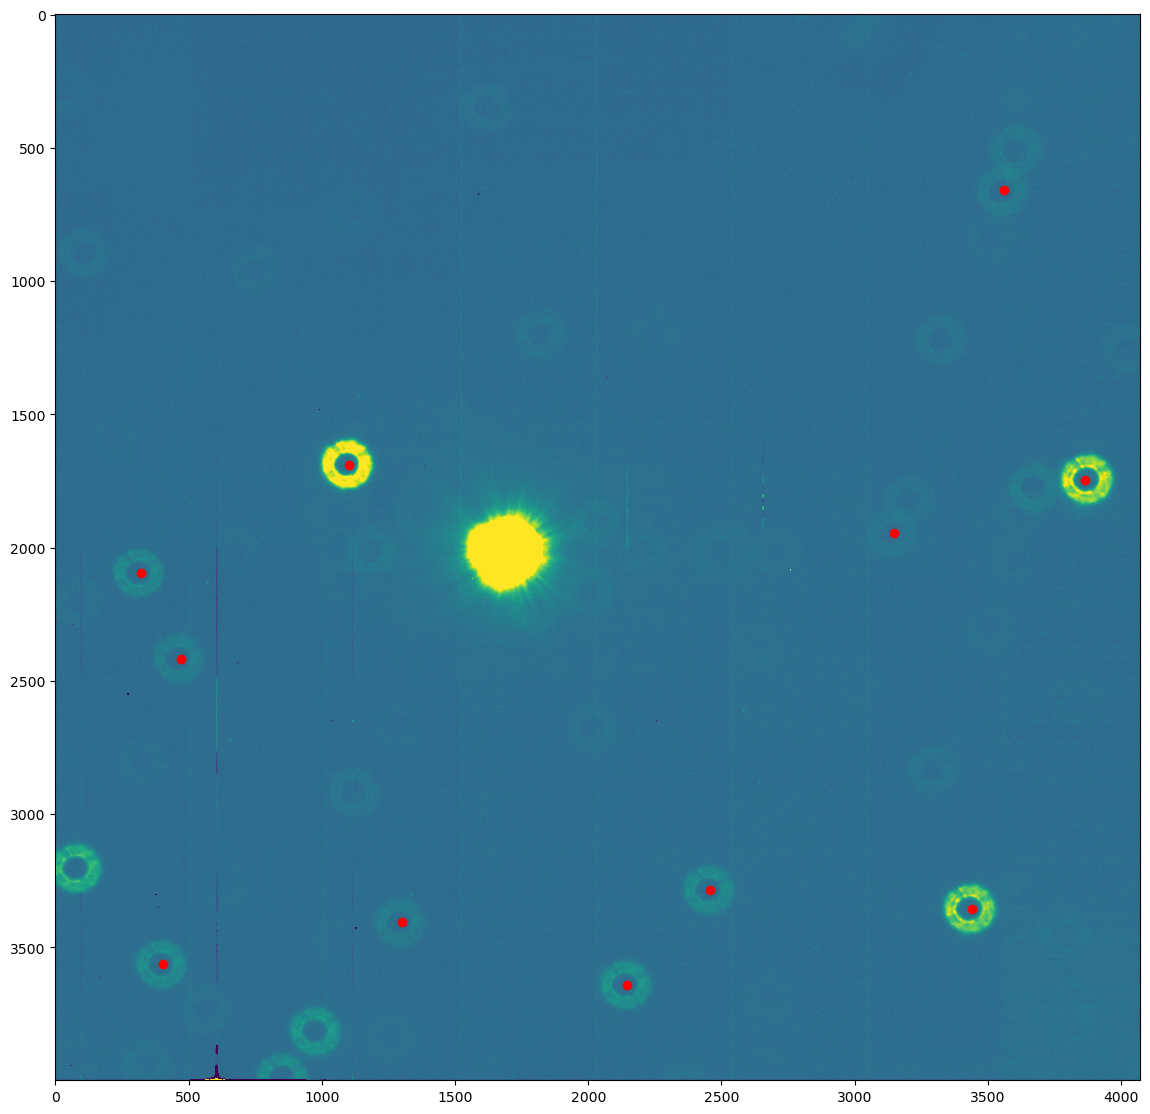

In [8]:
fig = plt.figure(figsize=(14,14))
plt.imshow(exposure_extra.getImage().getArray(), vmin=0, vmax=200)
plt.scatter(auxTelData['centroid_x'], auxTelData['centroid_y'], c='r')

## Use donut catalog to cut out donuts with CutOutDonutsScienceSensorTask

The donut catalog we get from `GenerateDonutDirectDetectTask` has the right format to use directly in the rest of the WEP pipeline. Here we take the image and the catalog and create donut stamps with `CutOutDonutsScienceSensorTask`.

In [9]:
from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import CutOutDonutsScienceSensorTaskConfig, CutOutDonutsScienceSensorTask

In [10]:
cutOutConfig = CutOutDonutsScienceSensorTaskConfig()
cutOutConfig.instObscuration = 0.3525
cutOutConfig.instFocalLength = 21.6
cutOutConfig.instApertureDiameter = 1.2
cutOutConfig.instDefocalOffset = 32.8
cutOutConfig.instPixelSize = 10.0e-6
cutOutConfig.opticalModel = 'onAxis'
cutOutConfig.donutStampSize = 200
cutOutConfig.donutTemplateSize = 200
cutOutConfig.initialCutoutPadding = 40

In [11]:
cutOutTask = CutOutDonutsScienceSensorTask(config=cutOutConfig)

In [12]:
cutOuts = cutOutTask.run([exposure_extra, exposure_intra], [auxTelData, auxTelData], camera)

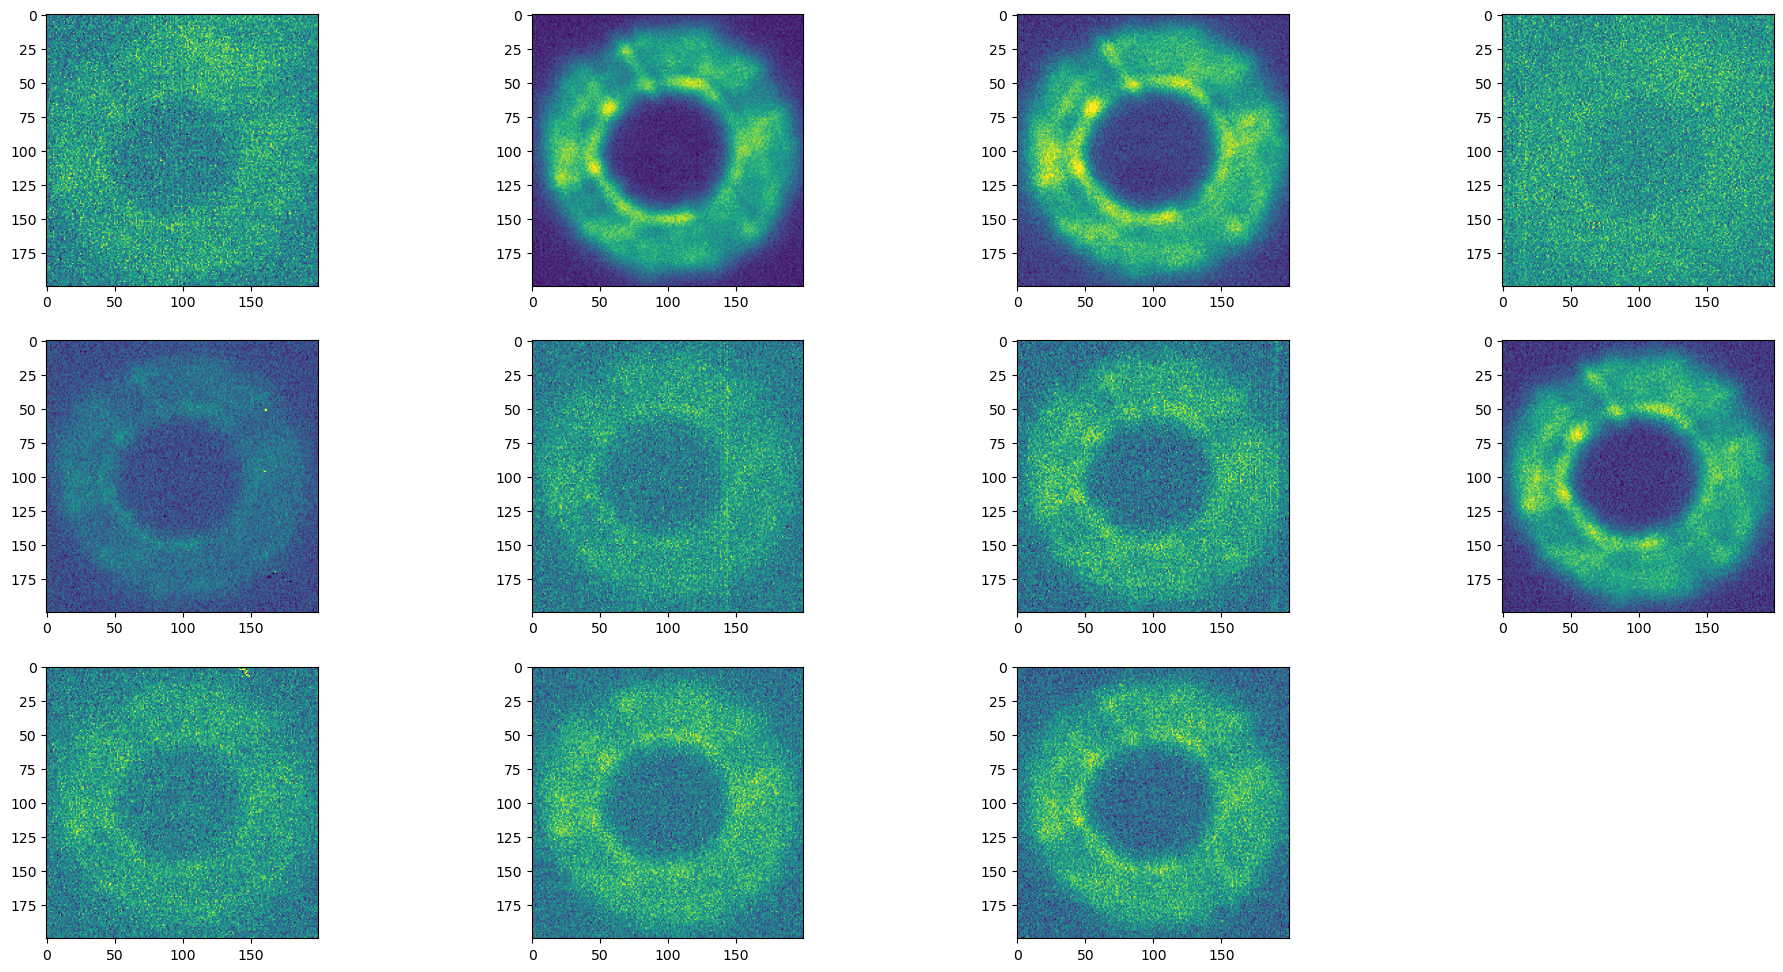

In [13]:
fig = plt.figure(figsize=(24, 12))
for i in range(len(auxTelData)):
    fig.add_subplot(3, 4, i+1)
    zscale = ZScaleInterval()
    data = cutOuts.donutStampsExtra[i].stamp_im.image.array
    vmin, vmax = zscale.get_limits(data)
    plt.imshow(data, vmin=vmin, vmax=vmax)

Here we see that all the donut stamps look good. The recentroiding step within the `donutStamp` generation was able to correctly center the donut at approximately (500, 2400) in the original catalog.

## Use donut catalog to fit a WCS

One of the objectives of the `GenerateDonutDirectDetectTask` is to enable WCS fitting on images that may have a poor original WCS solution. Here we demonstrate that the new task enables this to be done on real AuxTel data using the catalog generated above.

### Use original WCS to get a reference catalog

In [14]:
# Initialize with pointing information
info = exposure_extra.getInfo()
visitInfo = info.getVisitInfo()
boresightRa, boresightDec = visitInfo.boresightRaDec
boresightRotAng = visitInfo.boresightRotAngle

refCatInterface = RefCatalogInterface(boresightRa.asDegrees(), 
                                      boresightDec.asDegrees(), 
                                      boresightRotAng.asDegrees())

In [15]:
htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
refCatButler = Butler('/sdf/data/rubin/repo/main/')
catalogName = 'ps1_pv3_3pi_20170110'
collections = ['refcats/DM-28636']
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, refCatButler, catalogName, collections)

In [16]:
originalWcs = exposure_extra.getWcs()
print(originalWcs)

FITS standard SkyWcs:
Sky Origin: (156.7126895134, -30.0729918726)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel


In [17]:
refCatConfig = LoadReferenceObjectsConfig(anyFilterMapsToThis='g')

In [18]:
refCatLoader = ReferenceObjectLoader(dataIds, dataRefs, config=refCatConfig)
refCat = refCatLoader.loadSkyCircle(visitInfo.boresightRaDec, lsst.geom.Angle(0.01), 'g')

In [19]:
# Run source selection to trim the original reference catalog by magnitude
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 20
magLimit.fluxField = 'g_flux'
srcCatConfig = ReferenceSourceSelectorConfig()
srcCatConfig.doMagLimit = True
srcCatConfig.magLimit = magLimit

In [20]:
srcCatTask = ReferenceSourceSelectorTask(config=srcCatConfig)
srcCat = srcCatTask.run(refCat.refCat).sourceCat

In [21]:
# Get the pixel coordinates for sources based upon original WCS
srcX, srcY = originalWcs.skyToPixelArray(srcCat['coord_ra'], srcCat['coord_dec'])

Text(0.5, 1.0, 'Exposure with original WCS.')

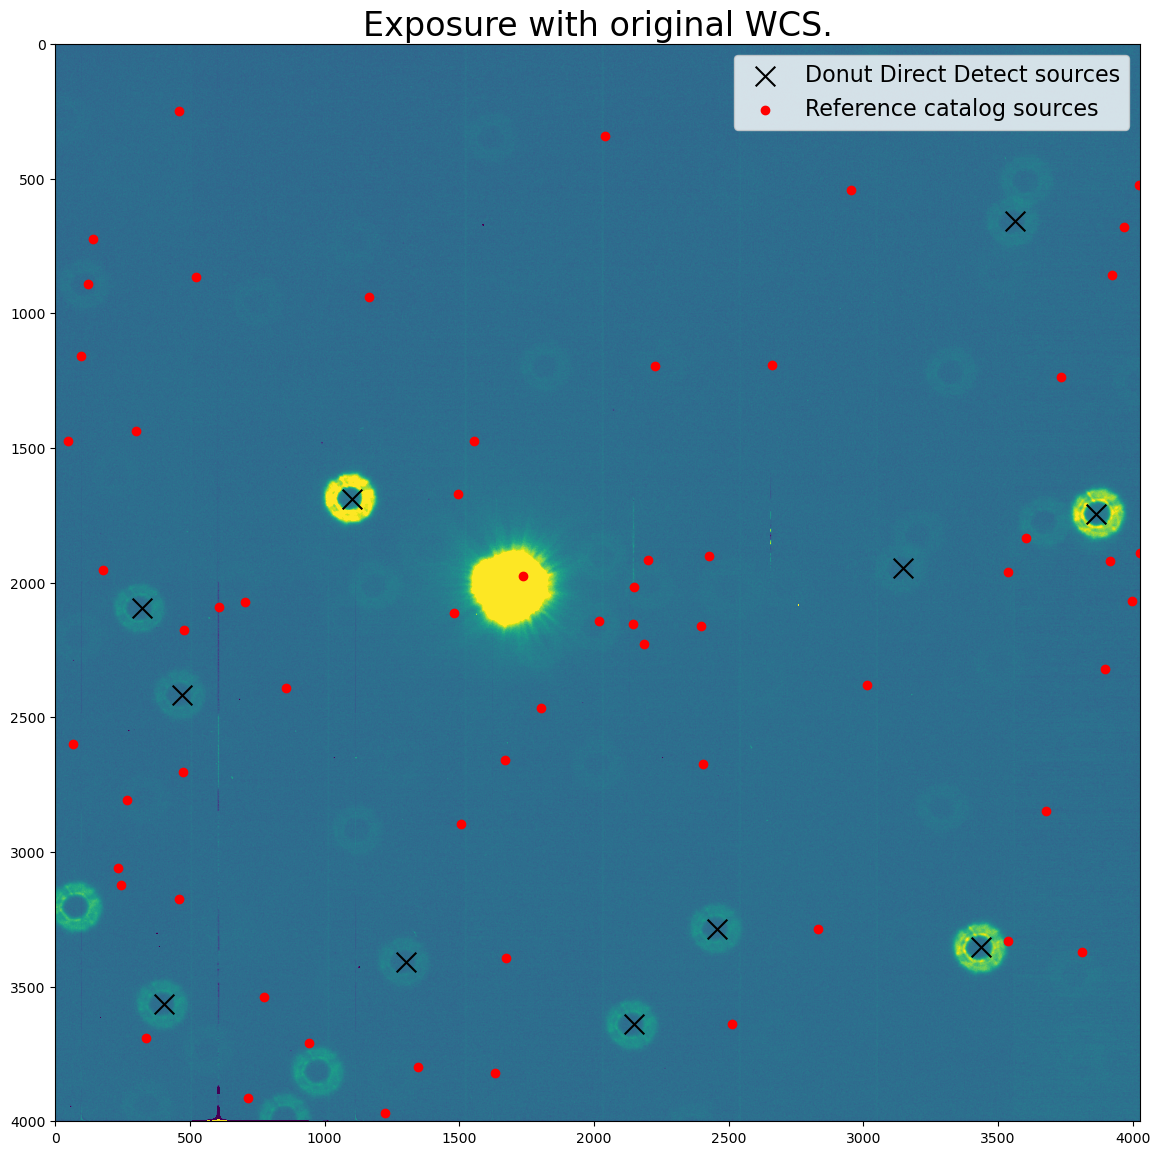

In [22]:
fig = plt.figure(figsize=(14,14))
plt.imshow(exposure_extra.getImage().getArray(), vmin=0, vmax=200)
plt.scatter(auxTelData['centroid_x'], auxTelData['centroid_y'], c='k', marker='x', s=200, label='Donut Direct Detect sources')
plt.scatter(srcX, srcY, c='r', label='Reference catalog sources')
plt.xlim(0, 4028)
plt.ylim(4000, 0)
plt.legend(fontsize=16)
plt.title('Exposure with original WCS.', size=24)

The original WCS is clearly off when plotting the reference catalog sources using the WCS information. Next we use our catalog created with `GenerateDonutDirectDetectTask` to fit a new WCS.

### Fit a new WCS based upon the DonutDirectDetect catalog

In [23]:
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
sourceCat = afwTable.SourceCatalog(sourceSchema)

sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
sourceIdKey = sourceSchema["id"].asKey()
sourceRAKey = sourceSchema["coord_ra"].asKey()
sourceDecKey = sourceSchema["coord_dec"].asKey()
sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

catalog = auxTelData
exposure_copy = copy(exposure_extra)

Nrows = len(catalog)
sourceCat.reserve(Nrows)

for i in range(Nrows):
    src = sourceCat.addNew()
    src.set(sourceIdKey, i)

    # set ra,dec
    ra = lsst.geom.Angle(catalog['coord_ra'].iloc[i], lsst.geom.radians)
    src.set(sourceRAKey, ra)

    dec = lsst.geom.Angle(catalog['coord_dec'].iloc[i], lsst.geom.radians)
    src.set(sourceDecKey, dec)

    # set the x,y centroid
    x = catalog['centroid_x'].iloc[i]
    y = catalog['centroid_y'].iloc[i]
    point = lsst.geom.Point2D(x,y)
    src.set(sourceCentroidKey, point)

    # set the flux and assume some small 1% flux error
    flux =  catalog['source_flux'].iloc[i]
    src.set(sourceInstFluxKey, flux)

    fluxErr = flux / 100.
    src.set(sourceInstFluxErrKey, fluxErr)

In [24]:
astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 6
magLimit.maximum = 20
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 1000
astromConfig.wcsFitter.order = 3
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 10

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refCatLoader, schema=schema,)
results = solver.run(sourceCat=sourceCat, exposure=exposure_copy,)

In [25]:
newWcs = exposure_copy.getWcs()

In [26]:
print(originalWcs)

FITS standard SkyWcs:
Sky Origin: (156.7126895134, -30.0729918726)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel


In [27]:
print(newWcs)

FITS standard SkyWcs:
Sky Origin: (156.7059884865, -30.0880948466)
Pixel Origin: (1830.88, 2610.12)
Pixel Scale: 0.0957567 arcsec/pixel


Comparing the new WCS we see that there is quite a shift but we were succesfully able to fit to a new WCS using the detected donuts.

### Plot the reference catalog with the new WCS

In [28]:
srcX, srcY = newWcs.skyToPixelArray(srcCat['coord_ra'], srcCat['coord_dec'])

In [29]:
# Sort the sources in the image by flux to plot only the brightest sources
inSensorIdx = np.where(((srcX > 0) & (srcX < 4028) & (srcY > 0) & (srcY < 4000)))
srcCatTrimmedFlux = srcCat['g_flux'][inSensorIdx]
fluxsort = inSensorIdx[0][np.argsort(srcCatTrimmedFlux)[::-1]]

Text(0.5, 1.0, 'Exposure with newly fit WCS.')

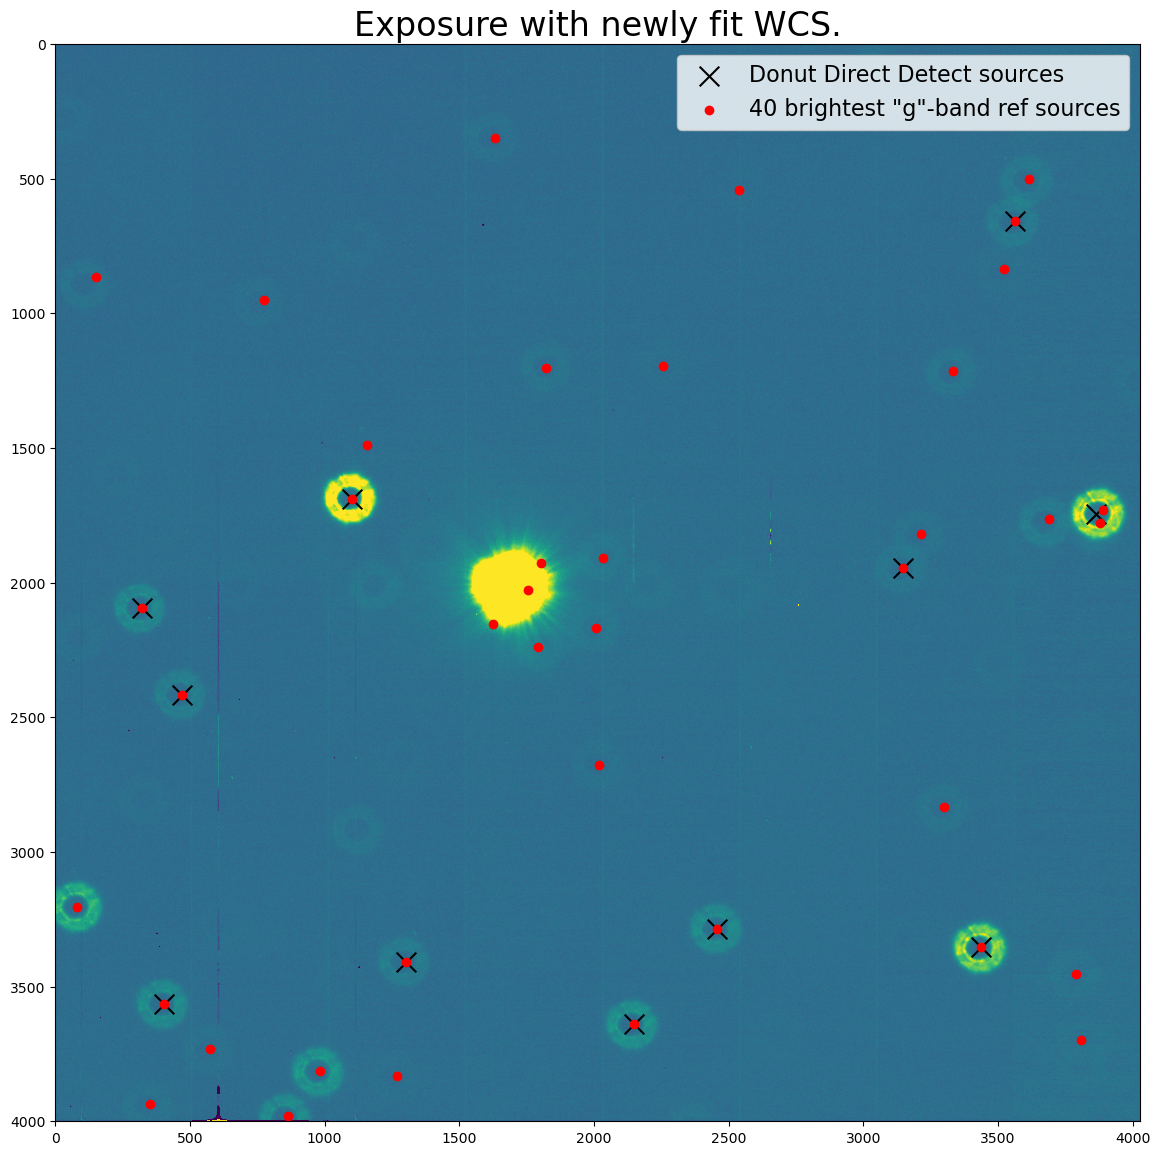

In [30]:
fig = plt.figure(figsize=(14,14))
plt.imshow(exposure_extra.getImage().getArray(), vmin=0, vmax=200)
plt.scatter(auxTelData['centroid_x'], auxTelData['centroid_y'], c='k', marker='x', s=200, label='Donut Direct Detect sources')
plt.scatter(srcX[fluxsort[:40]], srcY[fluxsort[:40]], c='r', label='40 brightest "g"-band ref sources')
plt.xlim(0, 4028)
plt.ylim(4000, 0)
plt.legend(fontsize=16)
plt.title('Exposure with newly fit WCS.', size=24)

Plotting the brightest 40 sources in the 'g'-band reference catalog we see that most of the brightest donuts have a source on top of them and that it does appear this WCS is correct and much more useful than the original.